# Retención de clientes (Churn) con ML en  PySpark. Básico

### Parte I

### Fases habituales del modelo de Machine Learning


La mayoría de proyectos de Data Science y generación de modelos de inteligencia artificial contienen unas fases comunes:
1. Importanción y limpieza de datos: se cargan los datos, normalmente en formato de DataFrame y se pre-procesan (eliminación de valores nulos, normalización, ingenieria de variables, etc)
2. División de datos de entrenamiento y de test
3. Entrenamiento y optimiazación del modelo 
4. Evaluación y despliegue del modelo



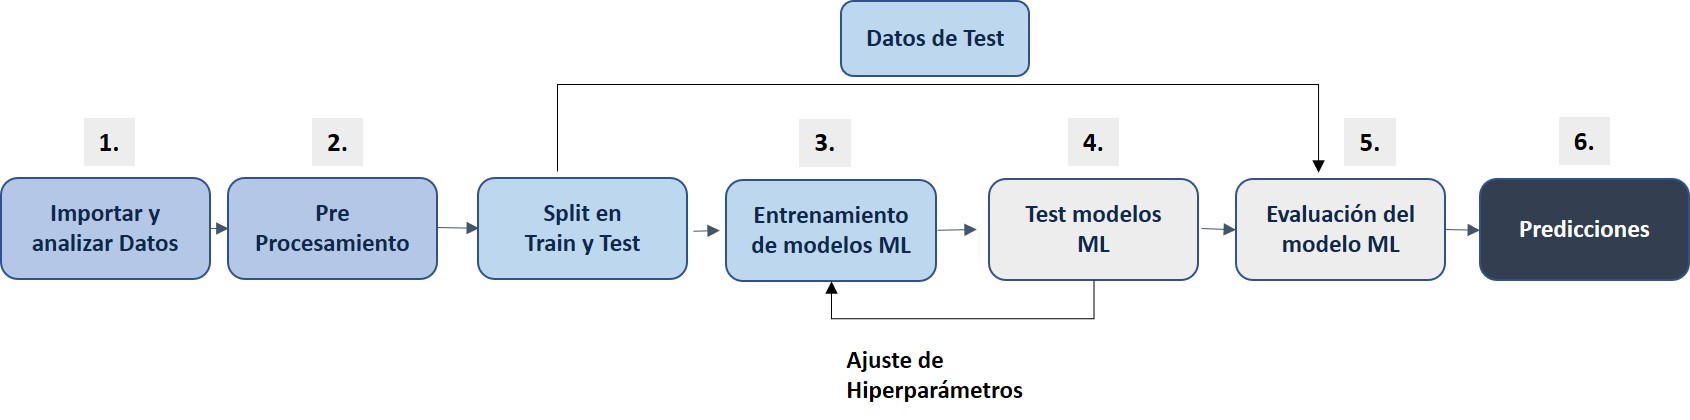

#### Tipo de Problema
**Objetivo:** Prediccion del churn de Cliente, para tratar de mantener el cliente o fidelizarlo

**Tipo de modelo de ML:** supervisado y clasificación binaria

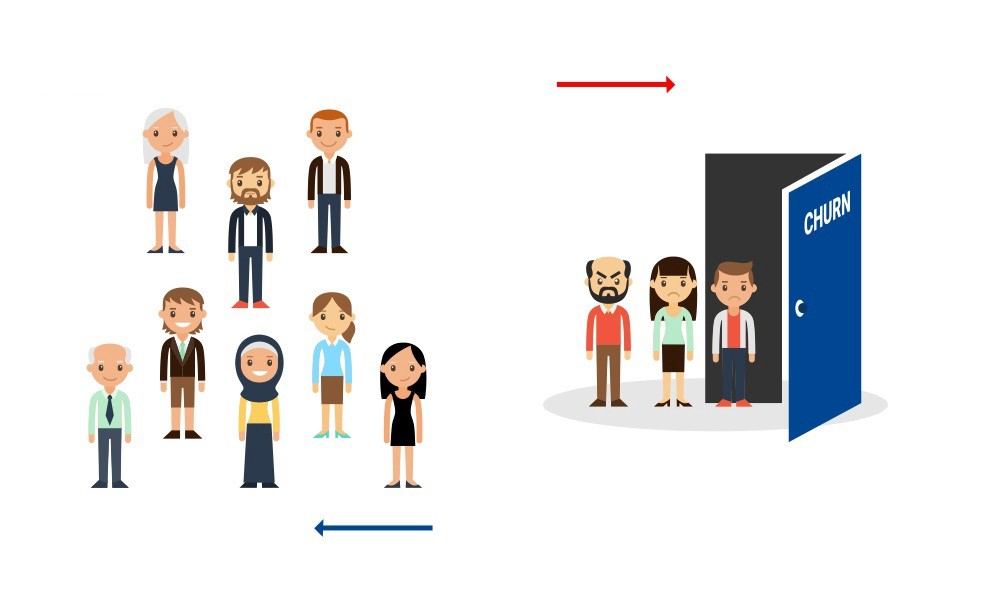

### Fase 1. Importación de datos en Spark

In [2]:
!pip install findspark

In [1]:
import findspark
findspark.init('/home/vieroh/apps/spark-3.3.0-bin-hadoop3-scala2.13')
import pandas as pd
import pyspark

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoder

#### Iniciar sesion de Spark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName('churnanalysis') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/21 17:59:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("Churn_Modelling.csv"))

In [142]:
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|        0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|        0|            2|        0|             0|       93826.63|

In [143]:
df.toPandas().head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.1,0


In [144]:
df.printSchema()

root
 |-- RowNumber: string (nullable = true)
 |-- CustomerId: string (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: string (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Tenure: string (nullable = true)
 |-- Balance: string (nullable = true)
 |-- NumOfProducts: string (nullable = true)
 |-- HasCrCard: string (nullable = true)
 |-- IsActiveMember: string (nullable = true)
 |-- EstimatedSalary: string (nullable = true)
 |-- Exited: string (nullable = true)



In [145]:
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|        0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|        0|            2|        0|             0|       93826.63|

In [146]:
df.count()

10000

In [147]:
df.dtypes

[('RowNumber', 'string'),
 ('CustomerId', 'string'),
 ('Surname', 'string'),
 ('CreditScore', 'string'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'string'),
 ('Tenure', 'string'),
 ('Balance', 'string'),
 ('NumOfProducts', 'string'),
 ('HasCrCard', 'string'),
 ('IsActiveMember', 'string'),
 ('EstimatedSalary', 'string'),
 ('Exited', 'string')]

In [148]:
# Basics stats from our columns
df.describe().toPandas()

,summary,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,mean,5000.5,1.56909405694E7,None,650.5288,None,None,38.9218,5.0128,76485.88928799961,1.5302,0.7055,0.5151,100090.2398809998,0.2037
2,stddev,2886.8956799071675,71936.18612274907,None,96.65329873613035,None,None,10.487806451704587,2.8921743770496837,62397.40520238599,0.5816543579989917,0.45584046447513327,0.49979692845891815,57510.49281769821,0.40276858399486065
3,min,1,15565701,Abazu,350,France,Female,18,0,0,1,0,0,100015.79,0
4,max,9999,15815690,Zuyeva,850,Spain,Male,92,9,99986.98,4,1,1,99984.86,1


In [149]:
df.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

### Fase 2. Pre-procesamiento de datos

#### Ajustar tipo de datos

In [150]:
from pyspark.sql.functions import col
dataset = df.select(col('CreditScore').cast('float'),
                         col('Age').cast('float'),
                         col('Tenure').cast('float'),
                         col('NumOfProducts').cast('float'),
                         col('HasCrCard').cast('float'),
                         col('IsActiveMember').cast('float'),
                         col('EstimatedSalary').cast('float'),
                         col('Balance').cast('float'),
                         col('Geography'),
                         col('Gender'),
                         col('Exited').cast('float')
                        )
dataset.head(5)

[Row(CreditScore=619.0, Age=42.0, Tenure=2.0, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=1.0, EstimatedSalary=101348.8828125, Balance=0.0, Geography='France', Gender='Female', Exited=1.0),
 Row(CreditScore=608.0, Age=41.0, Tenure=1.0, NumOfProducts=1.0, HasCrCard=0.0, IsActiveMember=1.0, EstimatedSalary=112542.578125, Balance=83807.859375, Geography='Spain', Gender='Female', Exited=0.0),
 Row(CreditScore=502.0, Age=42.0, Tenure=8.0, NumOfProducts=3.0, HasCrCard=1.0, IsActiveMember=0.0, EstimatedSalary=113931.5703125, Balance=159660.796875, Geography='France', Gender='Female', Exited=1.0),
 Row(CreditScore=699.0, Age=39.0, Tenure=1.0, NumOfProducts=2.0, HasCrCard=0.0, IsActiveMember=0.0, EstimatedSalary=93826.6328125, Balance=0.0, Geography='France', Gender='Female', Exited=0.0),
 Row(CreditScore=850.0, Age=43.0, Tenure=2.0, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=1.0, EstimatedSalary=79084.1015625, Balance=125510.8203125, Geography='Spain', Gender='Female', Exited=0.0)]

#### Eliminar columnas innecesarias

In [151]:
# Drop unnecessary columns
dataset = dataset.drop('RowNumber')
dataset = dataset.drop('CustomerId')
dataset = dataset.drop('Surname')

dataset.head(5)

[Row(CreditScore=619.0, Age=42.0, Tenure=2.0, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=1.0, EstimatedSalary=101348.8828125, Balance=0.0, Geography='France', Gender='Female', Exited=1.0),
 Row(CreditScore=608.0, Age=41.0, Tenure=1.0, NumOfProducts=1.0, HasCrCard=0.0, IsActiveMember=1.0, EstimatedSalary=112542.578125, Balance=83807.859375, Geography='Spain', Gender='Female', Exited=0.0),
 Row(CreditScore=502.0, Age=42.0, Tenure=8.0, NumOfProducts=3.0, HasCrCard=1.0, IsActiveMember=0.0, EstimatedSalary=113931.5703125, Balance=159660.796875, Geography='France', Gender='Female', Exited=1.0),
 Row(CreditScore=699.0, Age=39.0, Tenure=1.0, NumOfProducts=2.0, HasCrCard=0.0, IsActiveMember=0.0, EstimatedSalary=93826.6328125, Balance=0.0, Geography='France', Gender='Female', Exited=0.0),
 Row(CreditScore=850.0, Age=43.0, Tenure=2.0, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=1.0, EstimatedSalary=79084.1015625, Balance=125510.8203125, Geography='Spain', Gender='Female', Exited=0.0)]

#### Valores vacios

In [152]:
from pyspark.sql.functions import isnull, when, count, col
dataset.select([count(when(isnull(c), c)).alias(c) for c in dataset.columns]).show()

# Drop missing values
dataset = dataset.replace('null', None)\
        .dropna(how='any')

+-----------+---+------+-------------+---------+--------------+---------------+-------+---------+------+------+
|CreditScore|Age|Tenure|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Balance|Geography|Gender|Exited|
+-----------+---+------+-------------+---------+--------------+---------------+-------+---------+------+------+
|          0|  0|     0|            0|        0|             0|              0|      0|        0|     0|     0|
+-----------+---+------+-------------+---------+--------------+---------------+-------+---------+------+------+



#### De variables categoricas a numericas

In [154]:
from pyspark.ml.feature import StringIndexer
dataset = StringIndexer(
    inputCol='Gender', 
    outputCol='GenderIndex', 
    handleInvalid='keep').fit(dataset).transform(dataset)


In [155]:
dataset = StringIndexer(
    inputCol='Geography', 
    outputCol='GeographyNum', 
    handleInvalid='keep').fit(dataset).transform(dataset)

dataset = OneHotEncoder(
    inputCol='GeographyNum', 
    outputCol='GeographyIndex', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset.head(3)

+-----------+----+------+-------------+---------+--------------+---------------+---------+---------+------+------+-----------+------------+--------------+
|CreditScore| Age|Tenure|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|  Balance|Geography|Gender|Exited|GenderIndex|GeographyNum|GeographyIndex|
+-----------+----+------+-------------+---------+--------------+---------------+---------+---------+------+------+-----------+------------+--------------+
|      619.0|42.0|   2.0|          1.0|      1.0|           1.0|      101348.88|      0.0|   France|Female|   1.0|        1.0|         0.0| (4,[0],[1.0])|
|      608.0|41.0|   1.0|          1.0|      0.0|           1.0|      112542.58| 83807.86|    Spain|Female|   0.0|        1.0|         2.0| (4,[2],[1.0])|
|      502.0|42.0|   8.0|          3.0|      1.0|           0.0|      113931.57| 159660.8|   France|Female|   1.0|        1.0|         0.0| (4,[0],[1.0])|
|      699.0|39.0|   1.0|          2.0|      0.0|           0.0|      

In [156]:
dataset.dtypes

[('CreditScore', 'float'),
 ('Age', 'float'),
 ('Tenure', 'float'),
 ('NumOfProducts', 'float'),
 ('HasCrCard', 'float'),
 ('IsActiveMember', 'float'),
 ('EstimatedSalary', 'float'),
 ('Balance', 'float'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Exited', 'float'),
 ('GenderIndex', 'double'),
 ('GeographyNum', 'double'),
 ('GeographyIndex', 'vector')]

In [157]:
dataset.columns

['CreditScore',
 'Age',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Balance',
 'Geography',
 'Gender',
 'Exited',
 'GenderIndex',
 'GeographyNum',
 'GeographyIndex']

####  VectorAssembler

In [158]:
# Assemble all the features with VectorAssembler
required_features = ['CreditScore',
                     'Age',
                     'Tenure',
                     'NumOfProducts',
                     'HasCrCard',
                     'IsActiveMember',
                     'EstimatedSalary',
                     'Balance',
                     'GenderIndex',
                     'GeographyIndex']

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(dataset)

In [159]:
transformed_data.head()

Row(CreditScore=619.0, Age=42.0, Tenure=2.0, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=1.0, EstimatedSalary=101348.8828125, Balance=0.0, Geography='France', Gender='Female', Exited=1.0, GenderIndex=1.0, GeographyNum=0.0, GeographyIndex=SparseVector(4, {0: 1.0}), features=DenseVector([619.0, 42.0, 2.0, 1.0, 1.0, 1.0, 101348.8828, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]))

### Parte II

### Fase 3. Entrenamiento del modelo


#### Train Test Split

In [160]:
transformed_data=transformed_data.select('features','Exited') 

In [161]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))


Training Dataset Count: 8033
Test Dataset Count: 1967


#### Modelo de clasificación

In [162]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Exited', 
                            featuresCol='features',
                            maxDepth=5)

In [163]:
model = rf.fit(training_data)

In [164]:
# Predict with the test dataset
predictions = model.transform(test_data)

In [165]:
predictions.describe().show() 

+-------+-------------------+------------------+
|summary|             Exited|        prediction|
+-------+-------------------+------------------+
|  count|               1967|              1967|
|   mean|0.20132180986273512|0.0838840874428063|
| stddev|0.40108992105042746|0.2772843947845166|
|    min|                0.0|               0.0|
|    max|                1.0|               1.0|
+-------+-------------------+------------------+



### Fase 4. Evaluación del modelo

In [168]:

# Evaluate our model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol='Exited', 
    predictionCol='prediction', 
    metricName='accuracy')

In [169]:

# Accuracy
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.8500254194204372
